In [43]:
report_date = '2021-08-23 00:00:00'

In [2]:
# !pip install pandas
# !pip install pymssql
# !pip install sklearn
# !pip install pendulum

     |████████████████████████████████| 155 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 489 kB 11.0 MB/s eta 0:00:01


In [3]:
import pandas as pd
import pymssql
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.optimize import curve_fit
import datetime
import pendulum

In [4]:
def ms_sql_con():
    sql_name = 'voice_ai'
    sql_server = '10.2.4.124'
    sql_login = 'ICECORP\\1c_sql'

    with open('sql.pass','r') as file:
        sql_pass = file.read().replace('\n', '')
        file.close()

    return pymssql.connect(
            server = sql_server,
            user = sql_login,
            password = sql_pass,
            database = sql_name,
            # autocommit=True
        )

In [5]:
def read_sql(query):
    return pd.read_sql(query, con=ms_sql_con(), parse_dates=None)

In [6]:
def spent_time_vs_duration():
    print('spent time vs audio record duration')    
    df.plot(x="duration", y=["time"],  kind="scatter", colors = df['color'])
    plt.show()

In [7]:
def spent_time_vs_date():
    print('spent time on timeline')
    df['time_int'] = pd.to_timedelta(df.event_date).dt.total_seconds().astype(int)
    df['time_int'] = df['time_int'] - df.time_int.min()
    df.plot(x="time_int", y=["time"],  kind="scatter", colors = df['color'])
    plt.show()

In [8]:
def coef():
    x_train = np.array(df.duration).reshape(-1, 1)
    y_train = np.array(df.time).reshape(-1, 1)
    model = LinearRegression().fit(x_train, y_train)
    y_pred = model.predict(x_train)
    plt.scatter(x_train, y_train,  color='gray')
    plt.plot(x_train, y_pred, color='red', linewidth=2)
    plt.show()
    print('linear regression coef', model.coef_)
    return model.coef_[0][0]

In [9]:
def performance():
    
   
    print('performance: seconds of recognized audio per 10 min')
    counter = [0 for _ in range(int(df.time_int.max()/600))]
    
    for index, row in df.iterrows():
        cell = int(row.time_int/600)
        if len(counter) < cell + 1:
            counter.append(0)
        counter[cell] += row.duration   

    counter.insert(0,0)
    counter.pop(len(counter) - 1)
    plt.plot([x for x in range(len(counter))], counter, 'o', color='red', linewidth=2)
    plt.show()
    print([int(c) for c in counter])

In [10]:
def perf_cores():

    print('performance by cores count:')
    
    df['time_int'] = pd.to_timedelta(df.event_date).dt.total_seconds().astype(int)
    df['time_int'] = df['time_int'] - df.time_int.min()

    counter = [[] for _ in range(int(df.time_int.max()/600))]

    for index, row in df.iterrows():
        cell = int(row.time_int/600)
        if len(counter) < cell + 1:
            counter.append([])
        counter[cell].append(row.cores)

    cores = np.nan_to_num( [np.mean(c) for c in counter] )

    counter = [0 for _ in range(int(df.time_int.max()/600))]

    for index, row in df.iterrows():
        cell = int(row.time_int/600)
        if len(counter) < cell + 1:
            counter.append(0)
        counter[cell] += row.duration   

    counter.insert(0,0)
    counter.pop(len(counter) - 1)
    
    pc = pd.DataFrame([cores, counter]).T
    pc.columns = ['cores', 'time']
    pc = pd.DataFrame(pc.groupby('cores').mean())
    pc.reset_index(level=0, inplace=True)
    
    plt.plot(pc.cores, pc.time, 'o', color='red', linewidth=2)
    plt.show()

In [11]:
def cores_to_performance_calculated(report_date):
    
    print('cores count performance calculated:')
    
    query = "select cores, time, duration"
    query += " from perf_log "
    query += " where step = 2 and event_date > '"+report_date+"' and time > 5;"
    df = read_sql()
    df['td'] = df.time/df.duration
    df['perf'] = df.time/df.duration/df.cores
    df.drop(['duration','time'], axis=1, inplace=True)

    #meantd = df.groupby(df.cores).mean()
    #meantd.reset_index(level=0, inplace=True)
    #plt.plot(meantd.cores, meantd.td, 'o')

    #mediantd = df.groupby(df.cores).median()
    #mediantd.reset_index(level=0, inplace=True)
    #plt.plot(mediantd.cores, mediantd.td, 'o')

    mediantd = df.groupby(df.cores).median()
    mediantd.reset_index(level=0, inplace=True)
    plt.plot(mediantd.cores, mediantd.perf, 'o')

In [12]:
def reco_prognose():
    query = "select sum(duration) from queue"
    df_queued = pd.read_sql(query, con=ms_sql_con())
    queued_duration = float(df_queued.iloc[0])
    time_prognose = queued_duration * performance_coef
    print('recognize time prognose:', int(time_prognose), 'sec')
    print('or', int(time_prognose/60), 'min')
    print('or', int(time_prognose/60/60), 'h')
    print('or', int(time_prognose/60/60/24), 'd')

In [13]:
def colorator(source_id):
    return 'red' if source_id == 1 else 'green'

In [14]:
def earliest_records():
    print('earliest records')
    query = "select source_id, min(record_date) from queue group by source_id order by source_id;"
    df_queued = pd.read_sql(query, con=ms_sql_con())
    print(df_queued)

In [15]:
#query = "select event_date, cpu, time, duration from perf_log where step = 1 and duration<400 and time > 1000;"
#query = "select cpu, count(cpu) as cnt, sum(time) as time_sum from perf_log where step = 2 and time > 1000 group by cpu order by cpu;"
#query = "select event_date, time as time_sum from perf_log where step = 2 and cpu = 3 order by event_date;"

In [16]:
def plot_cpu_usage():
    df.groupby(['cpu']).sum().plot(y = ['time'], kind="bar")

In [17]:
def queue_time_vs_date():
    queue['color'] = queue['source_id'].apply(colorator)
    
    q_a = queue[queue.source_id == 1]
    q_b = queue[queue.source_id == 2]
    
    ratio = max(queue.queued_seconds_from_now) / max(queue.recorded_seconds_from_now) * 10
    fig, ax = plt.subplots(1, 1, figsize=(15, 10), dpi=80)
    
    ax.scatter(
        q_a.queued_seconds_from_now, 
        q_a.recorded_seconds_from_now, 
        color=q_a['color'],
        label="call",
         marker = 'x'
    )
    ax.scatter(
        q_b.queued_seconds_from_now, 
        q_b.recorded_seconds_from_now, 
        color=q_b['color'],
        label="mrm",
        marker = '.'
    )
    currentdate = datetime.datetime.today()
    currentdate = currentdate.strftime('%Y.%m.%d %H:%M:%S')
    #datetime.datetime.strptime(df, f_0).strftime(f_1)
    ax.set_title('Очередь ' + currentdate, fontsize=18)

    # Set common labels
    ax.set_xlabel('Добавлено, сек. назад', fontsize=18)
    ax.set_ylabel('Записано, сек. назад', fontsize=18)
    
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    plt.savefig('queue.png')

spent time vs audio record duration


/home/alex/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


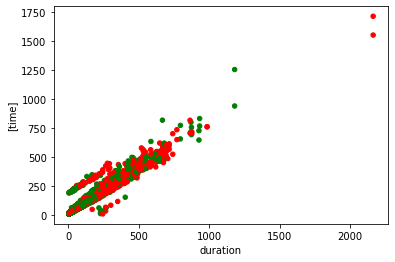

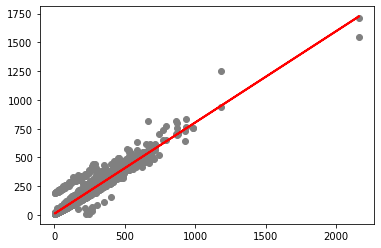

linear regression coef [[0.79431413]]
spent time on timeline


/home/alex/.local/lib/python3.7/site-packages/pandas/util/_decorators.py:208: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)
/home/alex/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


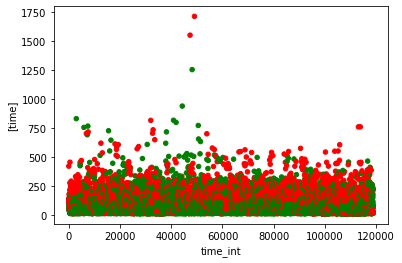

performance: seconds of recognized audio per 10 min


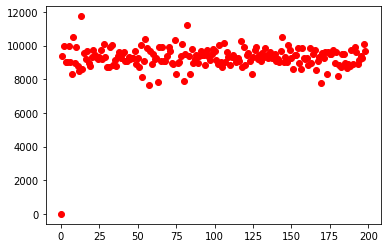

[0, 9369, 9992, 9028, 9014, 9948, 9015, 8284, 10501, 8946, 9900, 8811, 8501, 11743, 8593, 9577, 9184, 9652, 8939, 8779, 9339, 9765, 9435, 9293, 9193, 9304, 9720, 9198, 10093, 9350, 8749, 8747, 9930, 10035, 8844, 9129, 8797, 9408, 9647, 9244, 9524, 9639, 9066, 9056, 9297, 9174, 9260, 9260, 9689, 8919, 9235, 8711, 10048, 8124, 9086, 10396, 9856, 7682, 9696, 8901, 9503, 9194, 9276, 7809, 9894, 9084, 9919, 9092, 9073, 9371, 9922, 9696, 8946, 8906, 10338, 8333, 8995, 9007, 9363, 10076, 7880, 9507, 11200, 9379, 8288, 9815, 8943, 9197, 9413, 8949, 9358, 9694, 9414, 9416, 8841, 9742, 9400, 9165, 9515, 9806, 9668, 9137, 8919, 10045, 9019, 8732, 10142, 9045, 9618, 9348, 8858, 9310, 9446, 9272, 9014, 9240, 9089, 10296, 8741, 9925, 8862, 9463, 9551, 9058, 8295, 9315, 9713, 9905, 9232, 9451, 9088, 9539, 9319, 9871, 9455, 9263, 9604, 9279, 9347, 9509, 9069, 9214, 9035, 9703, 10509, 9023, 9293, 9035, 10055, 9749, 9250, 8638, 9446, 9446, 9867, 8952, 8604, 9851, 9239, 9189, 9260, 8838, 9832, 8973, 9474

/home/alex/.local/lib/python3.7/site-packages/pandas/util/_decorators.py:208: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)


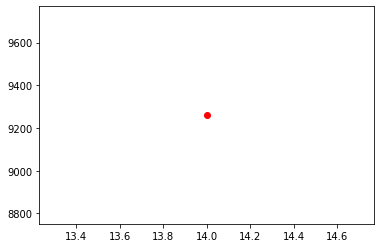

recognize time prognose: 637076 sec
or 10617 min
or 176 h
or 7 d
earliest records
   source_id                    
0          1 2021-04-13 18:29:45
1          2 2021-04-13 18:30:07


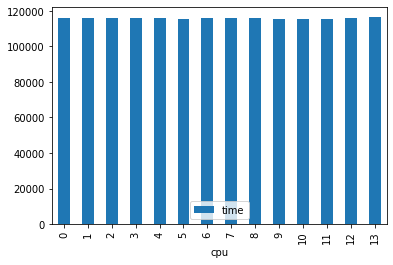

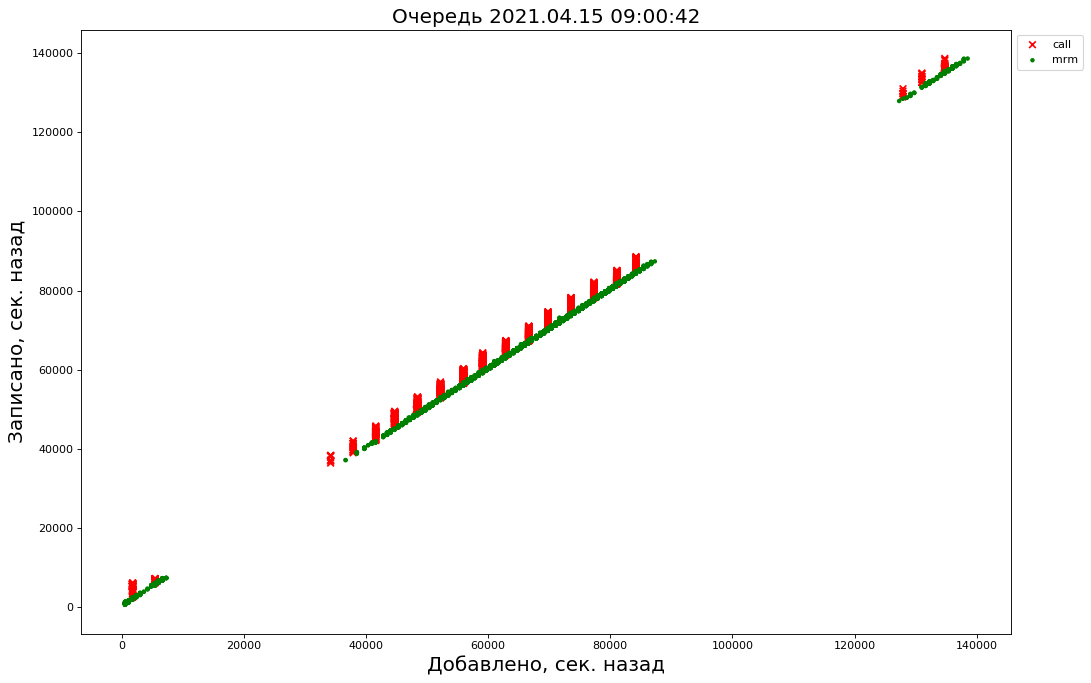

In [80]:
query = "select event_date, cpu, time, duration, source_id, cores"
query += " from perf_log "
#query += " where cores = 9 and step = 2 and event_date > '2021-03-12 15:27:00' and time > 5;"
query += " where step = 2 and event_date > '"+report_date+"' and time > 5;"
df = read_sql(query)
df['color'] = df['source_id'].apply(colorator)
spent_time_vs_duration()
performance_coef = coef()
#print('9 cores')
spent_time_vs_date()
performance()
perf_cores()
plot_cpu_usage()
reco_prognose()
earliest_records()

query = "select"
query += " source_id,"
query += " DATEDIFF(second, date, getdate()) as queued_seconds_from_now,"
query += " DATEDIFF(second, record_date, getdate()) as recorded_seconds_from_now"
query += " from queue order by record_date;"
queue = read_sql(query)
queue_time_vs_date()

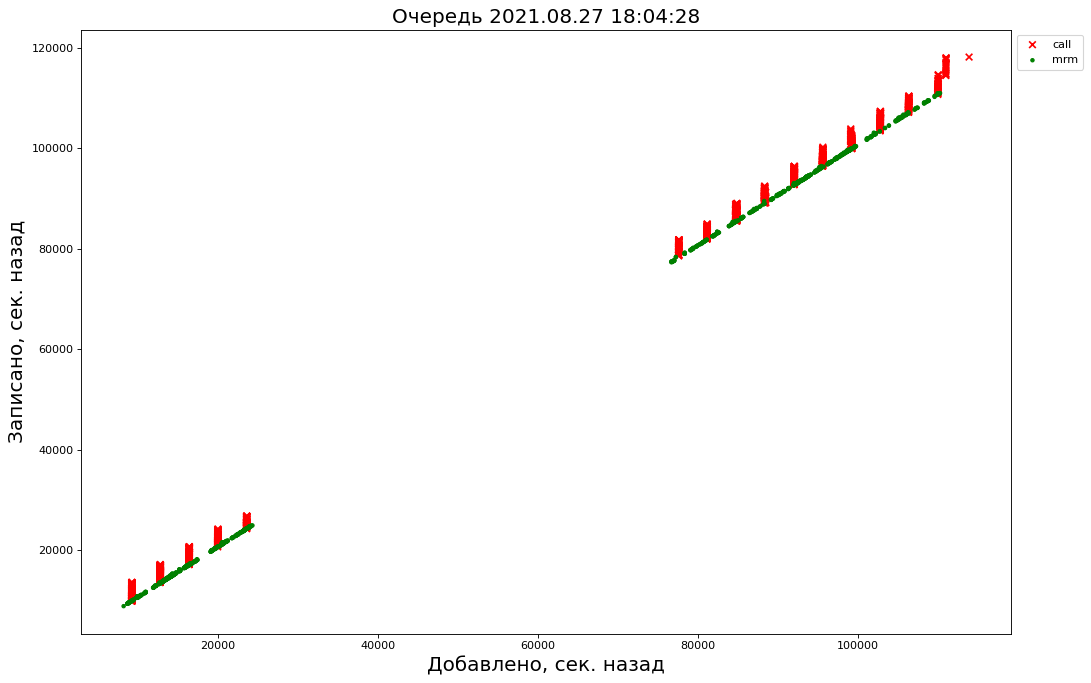

In [132]:
query = "select"
query += " source_id,"
query += " DATEDIFF(second, date, getdate()) as queued_seconds_from_now,"
query += " DATEDIFF(second, record_date, getdate()) as recorded_seconds_from_now"
query += " from queue order by record_date;"
queue = read_sql(query)
queue_time_vs_date()

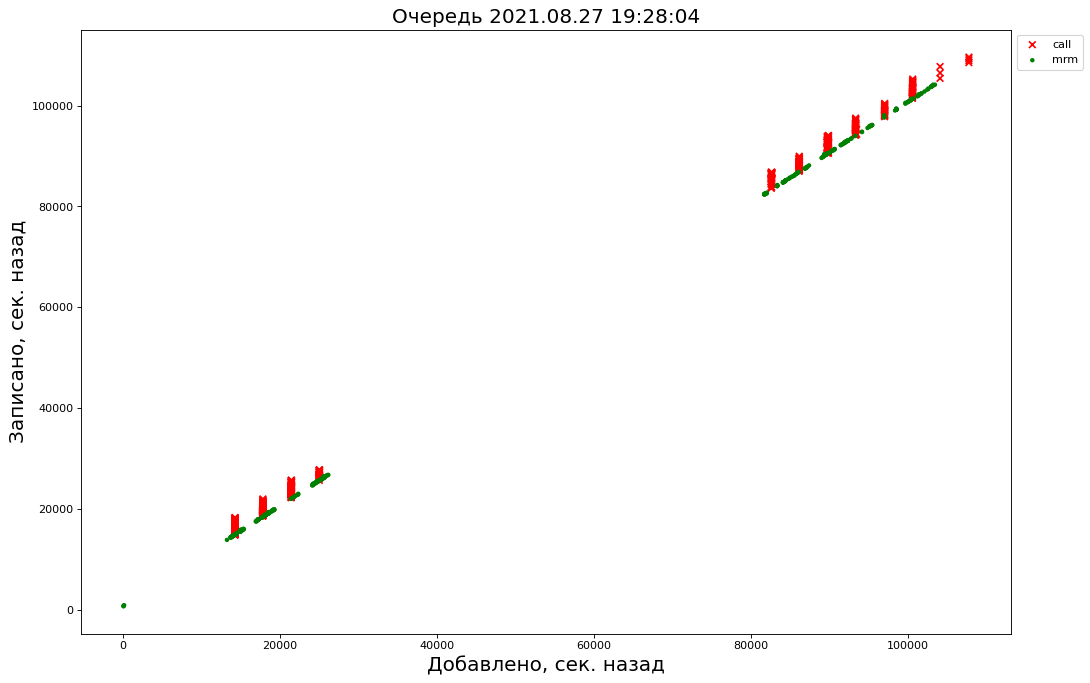

In [144]:
query = "select"
query += " source_id,"
query += " DATEDIFF(second, date, getdate()) as queued_seconds_from_now,"
query += " DATEDIFF(second, record_date, getdate()) as recorded_seconds_from_now"
query += " from queue order by record_date;"
queue = read_sql(query)
queue_time_vs_date()

In [81]:
#cores_to_performance_calculated()

In [82]:
# queue
query = "SELECT column_name FROM information_schema.columns WHERE table_name='queue';"
queue = read_sql(query)
queue

,column_name
0,date
1,cpu_id
2,filepath
3,date_y
4,date_m
5,date_d
6,filename
7,duration
8,record_date
9,source_id


In [83]:
query = "SELECT version, record_date, filename FROM queue order by record_date;"
queue = read_sql(query)
queue

,version,record_date,filename
0,0,2021-04-13 18:29:45,in_79055029008_2021-04-13-18-29-45rxtx.wav
1,1,2021-04-13 18:30:07,a2021-04-13t18:30:07b_c9099827168d_e8999820191...
2,0,2021-04-13 18:30:37,a2021-04-13t18:30:37b_c9111328570d_es_g1618327...
3,1,2021-04-13 18:32:36,a2021-04-13t18:32:36b_c1467d_e89041277107f_g16...
4,1,2021-04-13 18:33:41,a2021-04-13t18:33:41b_c9689595864d_e8915479879...
...,...,...,...
10882,1,2021-04-15 08:49:56,a2021-04-15t08:49:56b_c9031798162d_e8925000570...
10883,1,2021-04-15 08:50:02,a2021-04-15t08:50:02b_c9168145353d_e8926209048...
10884,1,2021-04-15 08:50:02,a2021-04-15t08:50:02b_c9168145353d_e8926209048...
10885,1,2021-04-15 08:50:22,a2021-04-15t08:50:22b_c9162577685d_e8916379835...


In [ ]:
# queue by cpu
query = "SELECT cpu_id, count(linkedid) FROM queue group by cpu_id order by cpu_id;"
queue = read_sql(query)
queue

In [151]:
# queue by cpu
query = "SELECT cpu_id, count(linkedid) FROM queue group by cpu_id order by count(linkedid) desc;"
queue = read_sql(query)
queue

,cpu_id,
0,19,119
1,10,104
2,11,93
3,17,83
4,9,82
5,8,81
6,15,63
7,12,63
8,21,62
9,18,44


In [153]:
# queue by cpu
query = "SELECT cpu_id, count(linkedid) FROM queue group by cpu_id order by count(linkedid) desc;"
queue = read_sql(query)
queue

,cpu_id,
0,19,101
1,11,82
2,10,80
3,8,73
4,17,65
5,9,64
6,15,51
7,12,44
8,21,41
9,18,25


### scratch

In [38]:
query = "SELECT column_name FROM information_schema.columns WHERE table_name='perf_log';"
df = read_sql(query)
df

,column_name
0,event_date
1,step
2,cpu
3,duration
4,linkedid
5,source_id
6,cores
7,time
8,file_name


In [146]:
start_date = '2021-08-27 19:20:00'
end_date = '2022-08-25 00:00:00'

query = "select file_name, cpu, time, duration"
query += " from perf_log "
query += " where step = 2 and event_date > '"+start_date+"' and time > 5"
query += " and event_date < '"+end_date+"';"
df = read_sql(query)
df['td'] = df.duration/df.time

<AxesSubplot:title={'center':'Транскрибация аудиофайлов'}, xlabel='Ядро', ylabel='Количество файлов'>

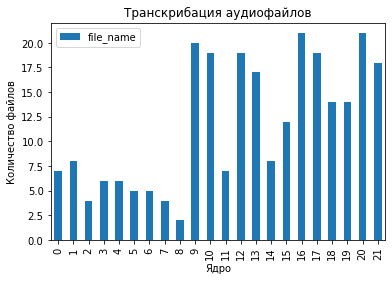

In [147]:
#df.groupby(['cpu']).count().plot(y = ['file_name'], kind="bar")
df.groupby('cpu').count().plot(
    y = ['file_name'], 
    kind="bar", 
    xlabel='Ядро', 
    ylabel='Количество файлов', 
    title='Транскрибация аудиофайлов'
)

In [148]:
df.drop(['file_name', 'time', 'duration'], axis=1, inplace = True)

<AxesSubplot:title={'center':'Медианная производительность транскрибации'}, xlabel='cpu', ylabel='Производительность'>

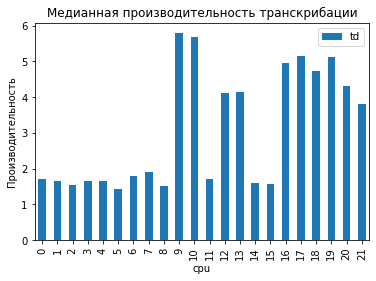

In [149]:
df.groupby('cpu').median().plot(
    y = ['td'], 
    kind="bar", 
    xlabel='cpu', 
    ylabel='Производительность', 
    title='Медианная производительность транскрибации'
)

<AxesSubplot:title={'center':'Средняя производительность транскрибации'}, xlabel='cpu', ylabel='Производительность'>

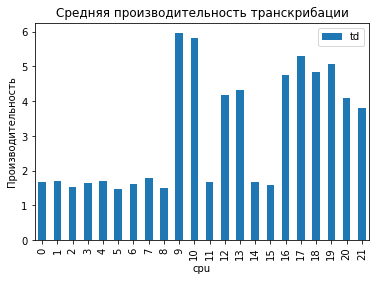

In [150]:
df.groupby('cpu').mean().plot(
    y = ['td'], 
    kind="bar", 
    xlabel='cpu', 
    ylabel='Производительность', 
    title='Средняя производительность транскрибации'
)

### check transcribations

In [21]:
# queue
query = "SELECT column_name FROM information_schema.columns WHERE table_name='transcribations';"
queue = read_sql(query)
queue

,column_name
0,transcribation_date
1,date_y
2,date_m
3,date_d
4,side
5,text
6,start
7,audio_file_name
8,conf
9,end_time


In [121]:
#report_date = '2021-08-23 14:06:17'
#report_date = '2021-08-24 11:25:00'
report_date = '2021-08-27 15:40:00'
query = "select top 300 source_id, cpu_id, linkedid, start, side, text"
#query = "select file_name, cpu"
query += " from transcribations "
query += " where cpu_id = 0 and transcribation_date > '"+report_date+"' "
query += " and duration > 5 and source_id = 2"
#query += " and audio_file_name = 'in_78632641676_2021-08-23-12-11-03rxtx.wav'"
query += " order by linkedid, start;"
df = read_sql(query)
df

,source_id,cpu_id,linkedid,start,side,text
0,2,0,1630048620.286021,14.880000,False,о да да здравствует деталях э ну давайте где т...
1,2,0,1630048620.286021,28.680000,False,ой сейчас давайте с трёх до пяти вот так лучше...
2,2,0,1630048620.286021,34.410000,False,ага все да договорились не сейчас
3,2,0,1630048649.286067,6.750000,False,и
4,2,0,1630048668.286102,0.060000,True,и
...,...,...,...,...,...,...
295,2,0,1630049507.286973,130.637021,False,да хорошо
296,2,0,1630049507.286973,133.290000,False,не знаю
297,2,0,1630049513.286981,0.000000,False,
298,2,0,1630049575.287044,24.240000,False,по поводу холодильник ограбить


In [61]:
df

,source_id,cpu_id,linkedid,start,side,text
0,1,0,1629709604.2051480,0.0,False,
1,1,0,1629709604.2051480,0.0,True,


In [82]:
for idx, row in df.iterrows():
    print(row.text)

глотали добрый день скажите ваша организация и замены резины накладки
замечательно да я
да все правильно
а на вторник
электролюкс с по-моему сейчас секундочку
электролюкс
но только их нет в продаже в россии
меня это не проблема нестандартное ужасе
улица лёни горько
он шестьдесят
квартира девяносто шесть
ты у нас очень большой большой дом с брендой третья аппаратная голикова этаж там будет на подъезде в и все написанное степной
метро проспект ветеранов наталья скажите пожалуйста вот знали на дверце холоднее герцог на стенку холодильника сзади тоже может обусловлено перейти на платное
или нет
она тебя оно сильно повреждена
я сейчас кайф девятьсот двадцать один
триста пятьдесят шесть
пятнадцать
дитя три нет я просто почему на вторник ниро надо разморозить холодильник там налить очень большая
да пусть первым мне все равно
да
ольга
и
трасса тебя видеофон бы сеанса татар зен чем могу помочь
да да
не знаю даже можем
секундочку вы можете сказать номер заявки или номер телефона которую оставлял

# DROP WRONG

In [78]:
start_date = '2021-08-23 15:10:00'
end_date = '2021-08-24 15:32:00'
query = "select top 100 source_id, cpu_id, linkedid, start, side, text"
#query = "select file_name, cpu"
query += " from transcribations "
query += " where cpu_id < 2"
query += " and source_id = 1"
query += " and transcribation_date > '"+start_date+"' "
query += " and transcribation_date < '"+end_date+"' "
query += " and duration > 5"
#query += " and audio_file_name = 'in_78632641676_2021-08-23-12-11-03rxtx.wav'"
query += " order by linkedid, start;"
df = read_sql(query)
df

,source_id,cpu_id,linkedid,start,side,text
0,1,1,1629357991.1954401,0.061233,True,и
1,1,1,1629357991.1954401,4.260000,True,здравствуйте единая служба сервиса оператора юля
2,1,1,1629357991.1954401,13.890000,True,стиральная машина какая как называется
3,1,1,1629357991.1954401,18.660000,True,мож черте города находятся территориально
4,1,1,1629357991.1954401,24.450000,True,вон в городе ли в области находитесь
...,...,...,...,...,...,...
95,1,1,1629358552.1954886,91.650000,False,покажи истории может быть ты принесёшь номер н...
96,1,1,1629358552.1954886,100.320000,False,серия дот
97,1,1,1629358552.1954886,102.030000,True,все всё этого достаточно больше ничего не надо...
98,1,1,1629358552.1954886,104.100000,False,позже эти у тебя


### queue

In [18]:
query = "SELECT column_name FROM information_schema.columns WHERE table_name='transcribations';"
queue = read_sql(query)
queue

,column_name
0,transcribation_date
1,date_y
2,date_m
3,date_d
4,side
5,text
6,start
7,audio_file_name
8,conf
9,end_time


In [ ]:
### server debug

In [33]:
batch_size = 100
cpu_id = 11
past_in_minutes = pendulum.now().add(minutes=-6).strftime('%Y-%m-%d %H:%M:%S')
sql_query = "select top "+str(batch_size)+" filepath, filename, duration, source_id, "
sql_query += "record_date, src, dst, linkedid, file_size, date from queue "
sql_query += "where cpu_id='" + str(cpu_id) + "' "
sql_query += "and ( (source_id = '2' and record_date < '" + past_in_minutes + "') or not source_id = '2' ) "
#sql_query += "order by ISNULL(record_date, 0) desc, record_date, linkedid, filename;"
sql_query += "order by record_date, filename;"

queue = read_sql(sql_query)
queue

,filepath,filename,duration,source_id,record_date,src,dst,linkedid,file_size,date
0,/mnt/share/audio/MSK_SRVCALL/RX_TX/RXTX_2021-0...,in_4996120291_2021-08-27-08-43-32rxtx.wav,68.16,1,2021-08-27 08:43:32,4996120291,5042,1630043011.2156553,2181164,2021-08-27 09:31:06
1,/mnt/share/audio/MSK_SRVCALL/RX_TX/RXTX_2021-0...,in_8127770011_2021-08-27-08-44-12rxtx.wav,9.24,1,2021-08-27 08:44:12,8127770011,5010,1630043050.2156576,295724,2021-08-27 09:31:06
2,/mnt/share/audio/MSK_SRVCALL/RX_TX/RXTX_2021-0...,in_8127770011_2021-08-27-08-44-44rxtx.wav,16.76,1,2021-08-27 08:44:44,8127770011,5042,1630043082.2156606,536364,2021-08-27 09:31:07
3,/mnt/share/audio/MSK_SRVCALL/RX_TX/RXTX_2021-0...,in_79063695054_2021-08-27-08-45-21rxtx.wav,7.94,1,2021-08-27 08:45:21,79063695054,None,1630043119.2156628,254124,2021-08-27 09:31:07
4,/mnt/share/audio/MSK_SRVCALL/RX_TX/RXTX_2021-0...,in_78314222525_2021-08-27-08-45-48rxtx.wav,49.96,1,2021-08-27 08:45:48,78314222525,5021,1630043147.2156666,1598764,2021-08-27 09:31:08
...,...,...,...,...,...,...,...,...,...,...
60,/mnt/share/audio_master/MSK_MRM/REC_IN_OUT/,a2021-08-27t09:31:07b_c9254214853d_e9857969400...,52.28,2,2021-08-27 09:31:07,9254214853,9857969400,1630045865.284160,836524,2021-08-27 09:42:26
61,/mnt/share/audio_master/MSK_MRM/REC_IN_OUT/,a2021-08-27t09:31:19b_c9811890939d_e9213497425...,34.60,2,2021-08-27 09:31:19,9811890939,9213497425,1630045877.284171,553644,2021-08-27 09:42:26
62,/mnt/share/audio_master/MSK_MRM/REC_IN_OUT/,a2021-08-27t09:31:19b_c9811890939d_e9213497425...,34.80,2,2021-08-27 09:31:19,9811890939,9213497425,1630045877.284171,556844,2021-08-27 09:42:26
63,/mnt/share/audio_master/MSK_MRM/REC_IN_OUT/,a2021-08-27t09:31:36b_c9957826046d_e9067370483...,36.98,2,2021-08-27 09:31:36,9957826046,9067370483,1630045894.284186,591724,2021-08-27 09:42:26
